# SpaceTools Code Guide and Examples
SpaceTools is a Python library designed to minimize boilerplate code in space engineering assignments, especially for tasks not central to space engineering itself e.g. such as generating visually appealing plots. If you have questions about using SpaceTools, or encounter a bug don’t hesitate to contact your tutor or post on the course discussion forum. General feedback and functionality requests are also welcome, however, it is unlikely that unnecessary updates to SpaceTools will be made during semester.

This notebook is fully encompassing, thus, some code examples may not be applicable to you yet. There is no obligation to understand the concepts in a block of code if you haven't yet covered the relevent course work.

## Environment Setup
This notebook is designed to run inside the space engineering Python virtual environment. If you are unsure how to set up the virtual environment, checkout the getting started guide available on Canvas. Once the virtual environment has been created, install Astropy and Poliastro into the environment:
> Note: These libraries are used for examples sake and are not required in order to use SpaceTools. You are not permitted to use Astropy and Poliastro for your assignments.

```bash
pip install astropy poliastro
```
Then import all required libraries by running the code block below:

In [2]:
%matplotlib inline

import spacetools
import spacetools.constants as const

import numpy as np
import matplotlib.pyplot as plt

from poliastro.bodies import Earth
from poliastro.twobody import Orbit
from astropy.time import Time, TimeDelta
from astropy.coordinates import GCRS, ITRS, EarthLocation, CartesianRepresentation
import astropy.units as u

# Constants
SpaceTools contains a module with standard space constants. You are by all means allowed to supplement these constants with your own constants file if the supplied constants do not suffice. Each constant is accessed like so:

In [3]:
import spacetools.constants as const
print(f"Mass of the Earth: {const.M_EARTH:.2e} kg")

Mass of the Earth: 5.97e+24 kg


All constants with units UTC are provided as a `datetime.datetime()` object. The exhaustive list of available constants is.:

<div align="center">

| Constant                              | Value                                  | Unit                         | Variable           |
|---------------------------------------|----------------------------------------|------------------------------|--------------------|
| Mass of Earth                         | $5.97219 \times 10^{24}$               | kg                           | `M_EARTH`          |
| Gravitational parameter of Earth      | $3.986004418 \times 10^{14}$           | m<sup>3</sup>/s<sup>2</sup>  | `MU_EARTH`         |
| Equatorial radius of Earth            | $6.378137 \times 10^{6}$               | m                            | `R_EQAT_EARTH`     |
| Polar radius of Earth                 | $6.356752 \times 10^{6}$               | m                            | `R_POLE_EARTH`     |
| Nominal radius of Earth               | $6.378137 \times 10^{6}$               | m                            | `R_EARTH`          |
| Earth ellipsoid eccentricity squared  | $6.69437999014 \times 10^{-3}$         | —                            | `E2_EARTH`         |
| Earth second zonal harmonic coeff.    | $1.082626925638815 \times 10^{-3}$     | —                            | `J2_EARTH`         |
| Rotation rate of Earth                | $7.2921159 \times 10^{-5}$             | rad/s                        | `ROT_V_EARTH`      |
| J2000 epoch                           | 2000-01-01 12:00:00 UTC                | UTC                | `J2000`            |
| Earth rotation angle at J2000         | $4.89496121272365$                     | rad                          | `J2000_ERA`        |
| Sidereal day length                   | $8.61641 \times 10^{4}$                | s                            | `SIDEREAL_DAY`     |
| Solar day length                      | $8.64 \times 10^{4}$                   | s                            | `SOLAR_DAY`        |
| Vernal equinox 2022-03-20             | 2022-03-20 11:33:00 UTC                | UTC datetime                 | `VERNAL_EQUINOX`   |
| Zero °C in Kelvin                     | $273.15$                               | K                            | `C_ZERO_K`         |
| Astronomical unit to metres           | $1.495978707 \times 10^{11}$           | m                            | `AU_TO_METRES`     |
| Metres to astronomical unit           | $6.6845871226706 \times 10^{-12}$      | AU                           | `METRES_TO_AU`     |
| Speed of light in vacuum              | $2.99792458 \times 10^{8}$             | m/s                          | `c`                |

</div>

## Example Orbit
Run the code block below to generate an example orbit, which we will use to plot.

In [4]:
# Define orbital elements
a = 20000 * u.km            # semi-major axis
ecc = 0.5 * u.one        # eccentricity
inc = 33 * u.deg         # inclination
raan = 45.0 * u.deg        # RA of ascending node
argp = 0 * u.deg        # argument of perigee
ta = 10.0 * u.deg          # true anomaly at epoch
epoch = Time("2025-08-05 00:00:00", scale="utc")

orbit = Orbit.from_classical(Earth, a, ecc, inc, raan, argp, ta, epoch=epoch)

T = TimeDelta(orbit.period, format="sec")
dt = 20

timestamps = np.arange(0, T.value, dt) * u.s
timestamps = np.append(timestamps, T.value * u.s)       # include end time

# Simulate orbit
traj = np.array([
    orbit.propagate(t) for t in timestamps
])

traj_eci = np.array([x.r.value for x in traj]).T

# Get Latitiude, Longitude and Altitude of orbit
gcrs = GCRS(
    CartesianRepresentation(
        traj_eci[0] * u.km,
        traj_eci[1] * u.km,
        traj_eci[2] * u.km,
    ),
    obstime=epoch + timestamps,          # one obstime per sample
)
itrs = gcrs.transform_to(ITRS(obstime=gcrs.obstime))
loc = EarthLocation.from_geocentric(itrs.x, itrs.y, itrs.z)

latlon = np.array([
    loc.lat.to_value(u.deg),
    loc.lon.to_value(u.deg)
])

# Plotting
Most functions provided by SpaceTools involve themselves with plotting. All plotting functions accept an axes object as their first argument and any Matplotlib keyword argument (e.g. `label=`, `linewidth=`) can also be used. A legend will automatically be included if a label is provided. You can use `ax.legend._remove()` to turn of the legend in the rare case you want to provide a label but not show the legend.

> **Note:** Spacetool's plotting functions only provide a starting point for your plots. You are still responsible for correctly formatting your plots, and saving them in the correct file format (e.g. pdf).

## Plotting in 2D
The `plot_orbit_2d` function plots an orbit over its orbital plane. It accepts the axes object you want to plot as the first argument, a (2 x N) or (3 x N) NumPy array of N position vectors, and any valid Matplotlib keyword argument:

```python
spacetools.plot_orbit_2d(ax: Axes, r: np.ndarray, **kwargs)
```

If you provide a (2 x N) array (i.e. vectors are already 2D), the function will plot the exact positions you provide. If you provide a (3 x N) array of ECI position vectors, the function will first project the position vectors onto the orbital plane, and plot the projection. Note that the projection is not equivalent to the perifocal frame.

Take the time to read the following code example. Note that the example provides a (3 x N) array (i.e. position vectors are 3D, not 2D). The projected orbit is displayed. Note that it is rotated. Consider varying the `raan` variable in the code block above, re-running the notebook and seeing how the 2D plot changes.

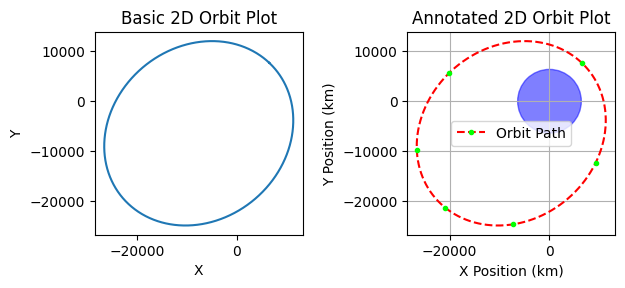

In [5]:
# Create a figure with two subplots.
fig = plt.figure()
ax_basic = fig.add_subplot(121)
ax_annotated = fig.add_subplot(122)

# Plot the basic 2D orbit plot.
spacetools.plot_orbit_2d(ax_basic, traj_eci)
ax_basic.set_title('Basic 2D Orbit Plot')

# Plot an annotated orbit This plot is quite ugly, but demonstrates how keyword arguments can be passed.
spacetools.plot_orbit_2d(
    ax_annotated,
    traj_eci,
    color='red',            # Pass in any valid matplotlib keyword arguments
    label='Orbit Path',     # Legend will be automatically generated if label is provided 
    linestyle='--',
    marker='o',
    markersize=3,
    markevery=250,
    markerfacecolor='lime',
    markeredgecolor='lime',
)

# Annotate the plot
ax_annotated.set_xlabel('X Position (km)')
ax_annotated.set_ylabel('Y Position (km)')
ax_annotated.set_title('Annotated 2D Orbit Plot')

ax_annotated.grid(True)
# ax_annotated.legend_.remove()     # Uncomment to remove the legend

# Plot earth as a circle
earth_circle = plt.Circle(
    (0, 0),
    const.R_EARTH * 1e-3,
    color='blue',
    alpha=0.5,
    label='Earth'
)
ax_annotated.add_artist(earth_circle)

fig.tight_layout()



## Plotting in 3D
The `plot_orbit_3d` function has the same interface as the 2D plotting function, however, this time the provided position vectors must be a (3 x N) NumPy array. You must also set the projection of the axes object to `'3d'`, otherwise the function will throw an exception.
```python
spacetools.plot_orbit_3d(ax: Axes, r: np.ndarray, **kwargs)
```

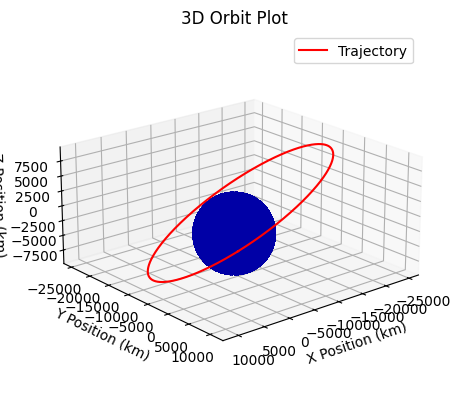

In [6]:
fig_3d = plt.figure()
ax_3d = fig_3d.add_subplot(111, projection='3d')

spacetools.plot_orbit_3d(ax_3d, traj_eci, color='red', label='Trajectory', zorder=20)
ax_3d.set_title('3D Orbit Plot')
ax_3d.set_xlabel('X Position (km)')
ax_3d.set_ylabel('Y Position (km)')
ax_3d.set_zlabel('Z Position (km)')
ax_3d.set_aspect('equal')   # Forces all axes to have the same scaling

# Plot earth as a sphere
earth_radius = const.R_EARTH * 1e-3
U, V = np.mgrid[0:2 * np.pi:100j, 0:np.pi:50j]
x = earth_radius * np.outer(np.cos(U), np.sin(V))
y = earth_radius * np.outer(np.sin(U), np.sin(V))
z = earth_radius * np.outer(np.ones(np.size(U)), np.cos(V))
ax_3d.plot_surface(x, y, z, color='blue', alpha=1, label='Earth', zorder=10)

ax_3d.view_init(elev=20, azim=50)  # Adjust the view angle for better visualization
ax_3d.grid(True)

## Generating Ground tracks
The `groundtrack` function is also provided. It has more arguments available than the 2D and 3D plotting functions. At a minimum, it requires the axes to plot on as the first argument and a (2 x N) array of latitude and longitude in degrees.
```python
spacetools.groundtrack(
    ax: Axes,
    latlon: np.ndarray,
    arrows=True,
    arrow_interval=3000,
    arrow_kwargs=dict()
    **kwargs
)
```
Just like the other plotting functions, all Matplotlib keyword arguments are valid arguments. There are also a number of options to control the arrows (which show the direction of motion) on the ground track. The `arrow_kwargs` argument is provided for flexibility, however, the default values of `arrow_kwargs` should be sufficient. Read [here](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.arrow.html) for `arrow_kwargs` documentation.

The function handles the 180 to -180 longitude discontinuity for you, and can plot multiple orbital periods, as long as the full trajectory is contained in `latlon`.

Play around with the code block below to familiarize yourself with the `groundtrack` function. 

Text(0.5, 1.0, 'Ground Track')

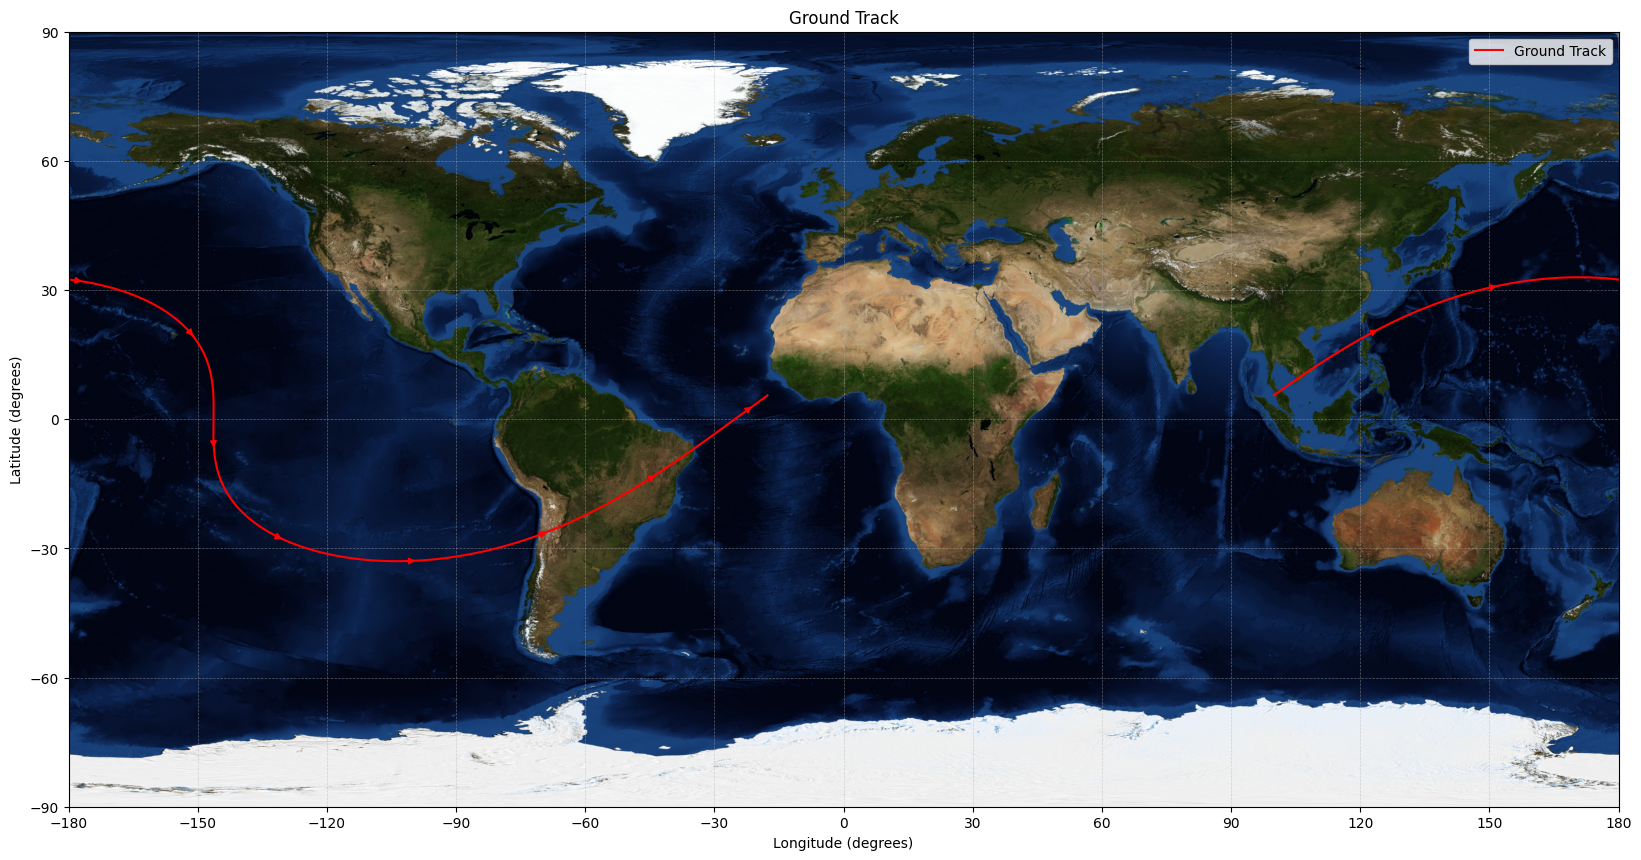

In [9]:
fig_groundtrack = plt.figure(figsize=(20, 20))
ax_groundtrack = fig_groundtrack.add_subplot(111)

spacetools.groundtrack(
    ax_groundtrack,
    latlon,
    arrows=True,                # True by default
    arrow_interval=3000,        # Interval between arrows in km, 3000 by default
    # Optional:
    arrow_kwargs={
        'linewidth': 1,         # Control arrow thickness
        'arrowstyle': '-|>',    # Arrow style, default is '-|>'. Try out '->'
        'mutation_scale': 10,   # Scale the size of the arrowhead (quite sensitive)
    },
    # Matplotlib keyword arguments:
    color='red',
    label='Ground Track',
)

ax_groundtrack.set_title('Ground Track')

## Azimuth-Elevation Plots
Azimuth-Elevation plots are also provided with the `azimuth_elevation` function. It has a similar interface to the `groundtrack` function, however, the provided axes object must have the projection set to `polar`, and `azel` is a (2 x N) NumPy array containing the azimuth and elevation in radians:
```python
azimuth_elevation(
    ax: Axes,
    azel: np.ndarray,
    rstep: float = 10
    arrows: bool = True,
    arrow_interval: float = 10,
    arrow_kwargs: dict = dict()
)
```
The `azimuth_elevation` function does not check whether the satellite is visible before plotting. You must ensure that every point in the `azel` argument is visible before calling the function, in order to generate a valid visibility plot. The function can handle multiple pass overs (i.e. multiple visibility periods) as along as they are contained in a single NumPy array.

To have different colours/labels for unique pass overs or satellites, you must call the `azimuth_elevation` plot successively, as shown below.

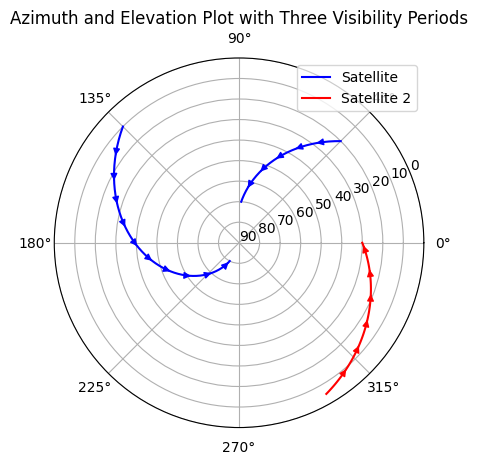

In [23]:
# Create dummy satellite azimuth and elevation data
azimuth_pass_1 = np.linspace(135, 243, 100)  # Azimuth in degrees
elevation_pass_1 = np.linspace(10, 80, 100)  # Elevation in degrees

azel_1 = np.deg2rad(np.vstack([azimuth_pass_1, elevation_pass_1]))

azimuth_pass_2 = np.linspace(45, 87, 100)
elevation_pass_2 = np.linspace(20, 70, 100)
azel_2 = np.deg2rad(np.vstack([azimuth_pass_2, elevation_pass_2]))

# Combine the two passes into a single array
azel = np.hstack((azel_1, azel_2))

# Create a third, but separate pass with different azimuth and elevation
azimuth_pass_3 = np.linspace(300, 360, 100)
elevation_pass_3 = np.linspace(5, 30, 100)
azel_3 = np.deg2rad(np.vstack([azimuth_pass_3, elevation_pass_3]))

# ---------- Plot azimuth and elevation
fig_azel = plt.figure()
ax = fig_azel.add_subplot(111, projection='polar')

spacetools.azimuth_elevation(
    ax,
    azel,
    rstep=10,       # Radial step size in degrees, default is 10
    arrows=True,    # True by default
    arrow_interval=10,  # Interval between arrows, 10 by default
    arrow_kwargs={
        'linewidth': 1,  # Control arrow thickness
        'arrowstyle': '-|>',  # Arrow style, default is '-|>'
        'mutation_scale': 10,  # Scale the size of the arrowhead (quite sensitive)
    },
    # Matplotlib keyword arguments:
    color='blue',
    label='Satellite',
)

# Plot the second pass separately
spacetools.azimuth_elevation(ax, azel_3, color='red', label='Satellite 2')

ax.set_title('Azimuth and Elevation Plot with Three Visibility Periods')
ax.legend(loc='upper right')